# Module 10 Supervised Machine Learning Techniques on Mortage Data

Yiheng Shen ys3323

This article is to build GBM model with grid search and cross validationand and the Deep Learning on a sample of the mortgage probability of default data. The criteria is ROC and the cumulative Lift.

## Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('XYZloan_default_selected_vars.csv')
df.shape

(80000, 89)

In [3]:
pd.set_option('display.max_columns', 100)
df.head(2)

,Unnamed: 0,Unnamed: 0.1,id,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,TD025,TD026,TD027,TD028,TD029,TD044,TD048,TD051,TD054,TD055,TD061,TD062,CR004,CR005,CR009,CR012,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,0,1,1,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,35807,0,4,4,3,2,-1.0,-1.0,-98.0,-98.0,-98.0,-98.0,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,79.0,125.0,103.0,43.0,55.0,56.0,52.0,65.0,91.0,96.0,10900.0,12757.0,8.0,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,1,2,2,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,7254,0,6,7,6,11,-1.0,-1.0,-98.0,-98.0,-98.0,-98.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,NaN,WEB


In [6]:
#df.info()

In [4]:
# drop columns with too many missing values
df = df.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1', 'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062'])

In [5]:
#check the values of -99, -98, -999
(df.PA028.value_counts()/len(df)).head(2)

-98.0    0.632988
-99.0    0.019175
Name: PA028, dtype: float64

In [6]:
(df.PA029.value_counts()/len(df)).head(2)

-98.0    0.663575
-99.0    0.019175
Name: PA029, dtype: float64

In [7]:
(df.PA030.value_counts()/len(df)).head(2)

-98.0    0.848575
-99.0    0.019175
Name: PA030, dtype: float64

In [8]:
(df.PA031.value_counts()/len(df)).head(2)

-98.0    0.700050
-99.0    0.019175
Name: PA031, dtype: float64

In [9]:
# these columns have too many -99 and -98, need to be dropped
df = df.drop(columns = ['PA028', 'PA029', 'PA030', 'PA031'])

In [10]:
# drop rows with too many -99, -98, -999
for index, row in df.iterrows():
    if row['PA022'] == -99.0 and row['PA023'] == -99.0 and row['CD008'] == -99.0:
        df.drop(index, inplace=True)   

In [11]:
#check missing values
df.isna().sum()

id                 0
loan_default       0
AP001              0
AP002              0
AP003              0
                ... 
CD170            381
CD172            381
CD173            381
MB005           1553
MB007              0
Length: 76, dtype: int64

In [12]:
#drop missing values
df = df.dropna()

### Random Undersampling

In [13]:
from imblearn.under_sampling import RandomUnderSampler

y = df["loan_default"].copy()
rus = RandomUnderSampler(random_state=0)
df_resampled, y_resampled = rus.fit_sample(df, y)

In [14]:
len(df_resampled)

23872

### Label Encoder

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False)
AP005 = ohe.fit_transform(df_resampled[['AP005']])
df_resampled['AP005'] = AP005

AP006 = ohe.fit_transform(df_resampled[['AP006']])
df_resampled['AP006'] = AP006

MB007 = ohe.fit_transform(df_resampled[['MB007']])
df_resampled['MB007'] = MB007

### Split Data

In [16]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_resampled, test_size=0.30, random_state=0)

## (1) GLM

In [17]:
import h2o
h2o.init()
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/yihengshen/.local/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmprnwjqr17
  JVM stdout: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmprnwjqr17/h2o_yihengshen_started_from_python.out
  JVM stderr: /var/folders/7t/kxwj0tvn11s88d879bt0277w0000gn/T/tmprnwjqr17/h2o_yihengshen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,1 month and 26 days
H2O_cluster_name:,H2O_from_python_yihengshen_99nnac
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [18]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
predictors = ['AP001', 'AP002', 'AP003', 'AP004', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 
              'TD005', 'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023', 'TD024', 'TD025', 
              'TD026', 'TD027', 'TD028', 'TD029', 'CR004', 'CR005', 'CR009', 'CR012', 'CR015', 'CR017', 'CR018', 
              'CR019', 'PA022', 'PA023', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 
              'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130', 
              'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 
              'CD166', 'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005', 'MB007']
target = "loan_default"

In [31]:
#No regularization
glm_model = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True)

glm_model.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [58]:
from h2o.grid.grid_search import H2OGridSearch

In [78]:
#lasso -- L1 penalty
hyper_params = {'alpha': [1],
                'lambda': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}
lasso_model = H2OGeneralizedLinearEstimator(family= "binomial")

grid = H2OGridSearch(model = lasso_model, 
                     hyper_params = hyper_params)

grid.train(predictors,target,training_frame=train_hex)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [79]:
best_lambda = grid.sorted_metric_table()['lambda'][0]
best_lambda

'[0.01]'

In [80]:
lasso = H2OGeneralizedLinearEstimator(family= "binomial",
                                      alpha = 1,
                                      lambda_ = 0.01)
lasso.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [90]:
#ridge -- L2 penalty
hyper_params = {'alpha': [0],
                'lambda': [0.01, 0.1, 0.25, 0.5, 0.75, 1]}
ridge_model = H2OGeneralizedLinearEstimator(family= "binomial")

grid = H2OGridSearch(model = ridge_model, 
                     hyper_params = hyper_params)

grid.train(predictors,target,training_frame=train_hex)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [91]:
best_lambda = grid.sorted_metric_table()['lambda'][0]
best_lambda

'[0.01]'

In [84]:
ridge = H2OGeneralizedLinearEstimator(family= "binomial",
                                      alpha = 0,
                                      lambda_ = 0.01)
ridge.train(predictors,target,training_frame=train_hex)

glm Model Build progress: |███████████████████████████████████████████████| 100%


### model evaluation

In [23]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [32]:
def ROC_LIFT(my_result,df,target):    
    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    y_pred = y_pred['predict']
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)

    # plotting
    plt.figure(figsize=(5,5))
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')
    
    #LIFT Table
    predictions = my_result.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    
    return(gains)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,717,393,324,717,393,324,0.11,0.09,353.4,1.11,2.0,54.81
1,716,406,310,1433,799,634,0.23,0.17,706.8,1.13,6.0,55.76
2,716,387,329,2149,1186,963,0.34,0.27,1060.2,1.12,7.0,55.19
3,716,401,315,2865,1587,1278,0.45,0.35,1413.6,1.12,10.0,55.39
4,716,373,343,3581,1960,1621,0.55,0.45,1767.0,1.11,10.0,54.73
5,717,401,316,4298,2361,1937,0.67,0.53,2120.4,1.11,14.0,54.93
6,716,394,322,5014,2755,2259,0.78,0.62,2473.8,1.11,16.0,54.95
7,716,407,309,5730,3162,2568,0.89,0.71,2827.2,1.12,18.0,55.18
8,716,198,518,6446,3360,3086,0.95,0.85,3180.6,1.06,10.0,52.13


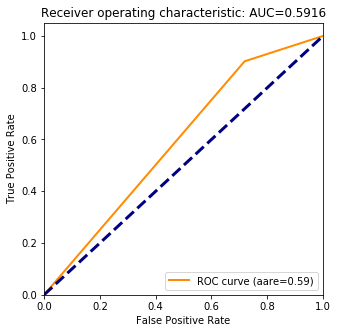

In [33]:
ROC_LIFT(glm_model,test_hex,'loan_default')

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,717,389,328,717,389,328,0.11,0.09,353.4,1.10,2.0,54.25
1,716,389,327,1433,778,655,0.22,0.18,706.8,1.10,4.0,54.29
2,716,388,328,2149,1166,983,0.33,0.27,1060.2,1.10,6.0,54.26
3,716,401,315,2865,1567,1298,0.44,0.36,1413.6,1.11,8.0,54.69
4,716,379,337,3581,1946,1635,0.55,0.45,1767.0,1.10,10.0,54.34
5,717,396,321,4298,2342,1956,0.66,0.54,2120.4,1.10,12.0,54.49
6,716,373,343,5014,2715,2299,0.77,0.63,2473.8,1.10,14.0,54.15
7,716,409,307,5730,3124,2606,0.88,0.72,2827.2,1.10,16.0,54.52
8,716,246,470,6446,3370,3076,0.95,0.85,3180.6,1.06,10.0,52.28


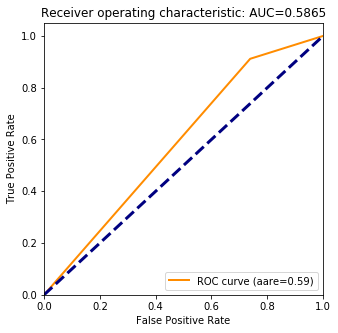

In [81]:
ROC_LIFT(lasso,test_hex,'loan_default')

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,717,397,320,717,397,320,0.11,0.09,353.4,1.12,2.0,55.37
1,716,408,308,1433,805,628,0.23,0.17,706.8,1.14,6.0,56.18
2,716,395,321,2149,1200,949,0.34,0.26,1060.2,1.13,8.0,55.84
3,716,400,316,2865,1600,1265,0.45,0.35,1413.6,1.13,10.0,55.85
4,716,374,342,3581,1974,1607,0.56,0.44,1767.0,1.12,12.0,55.12
5,717,409,308,4298,2383,1915,0.67,0.53,2120.4,1.12,14.0,55.44
6,716,396,320,5014,2779,2235,0.79,0.62,2473.8,1.12,17.0,55.42
7,716,388,328,5730,3167,2563,0.90,0.71,2827.2,1.12,19.0,55.27
8,716,183,533,6446,3350,3096,0.95,0.85,3180.6,1.05,10.0,51.97


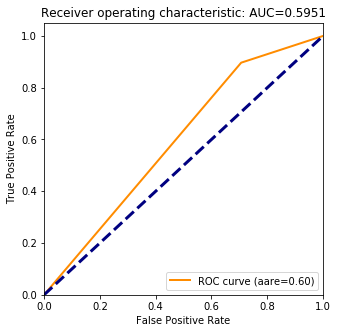

In [85]:
ROC_LIFT(ridge,test_hex,'loan_default')

## (2) auto ML

In [86]:
from h2o.automl import H2OAutoML

In [87]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_v1 = H2OAutoML(max_runtime_secs = 60, max_models=20, seed=1)
aml_v1.train(predictors,target,training_frame=train_hex)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [88]:
aml_v1.leaderboard.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201123_203149,0.222297,0.471484,0.222297,0.444665,0.330989
StackedEnsemble_BestOfFamily_AutoML_20201123_203149,0.222996,0.472224,0.222996,0.446058,0.331521
DeepLearning_1_AutoML_20201123_203149,0.228535,0.478054,0.228535,0.44929,0.335768
GBM_grid__1_AutoML_20201123_203149_model_1,0.228939,0.478476,0.228939,0.458632,0.335822
XGBoost_grid__1_AutoML_20201123_203149_model_1,0.232567,0.482252,0.232567,0.443996,0.337598
GLM_1_AutoML_20201123_203149,0.234285,0.48403,0.234285,0.477553,0.340516
XGBoost_3_AutoML_20201123_203149,0.236389,0.486199,0.236389,0.478761,0.341794
GBM_3_AutoML_20201123_203149,0.238104,0.487959,0.238104,0.485195,0.343421
GBM_2_AutoML_20201123_203149,0.24019,0.490092,0.24019,0.48816,0.344873
GBM_4_AutoML_20201123_203149,0.240237,0.49014,0.240237,0.487454,0.344844


In [89]:
pred = aml_v1.predict(test_hex)
pred.head()

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
0.638321
0.332114
0.24191
0.569041
0.115487
0.594672
0.633705
0.636563
0.487503
0.34062


In [92]:
perf = aml_v1.leader.model_performance(test_hex)
perf


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.2232380273205286
RMSE: 0.47248071634779826
MAE: 0.4475589060095846
RMSLE: 0.3342140069306052
R^2: 0.10689404335378505
Mean Residual Deviance: 0.2232380273205286
Null degrees of freedom: 7161
Residual degrees of freedom: 7148
Null deviance: 1790.8210526528203
Residual deviance: 1598.830751669626
AIC: 9615.337018085407


stackedensemble prediction progress: |████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,717,542,175,717,542,175,0.15,0.05,353.4,1.53,10.0,75.59
1,716,480,236,1433,1022,411,0.29,0.11,706.8,1.45,18.0,71.32
2,716,439,277,2149,1461,688,0.41,0.19,1060.2,1.38,22.0,67.99
3,716,412,304,2865,1873,992,0.53,0.27,1413.6,1.32,26.0,65.38
4,716,368,348,3581,2241,1340,0.63,0.37,1767.0,1.27,26.0,62.58
5,717,345,372,4298,2586,1712,0.73,0.47,2120.4,1.22,26.0,60.17
6,716,328,388,5014,2914,2100,0.82,0.58,2473.8,1.18,24.0,58.12
7,716,261,455,5730,3175,2555,0.90,0.70,2827.2,1.12,20.0,55.41
8,716,241,475,6446,3416,3030,0.97,0.84,3180.6,1.07,13.0,52.99


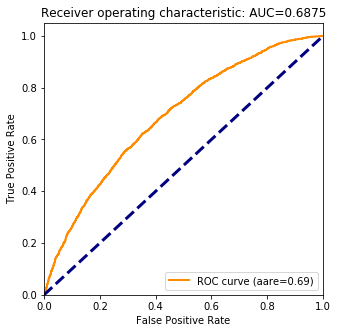

In [93]:
ROC_LIFT(aml_v1,test_hex,'loan_default')